In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate, io, signal

## Preprocessing

Text(0.5, 0.98, 'ECG Signals with Trends')

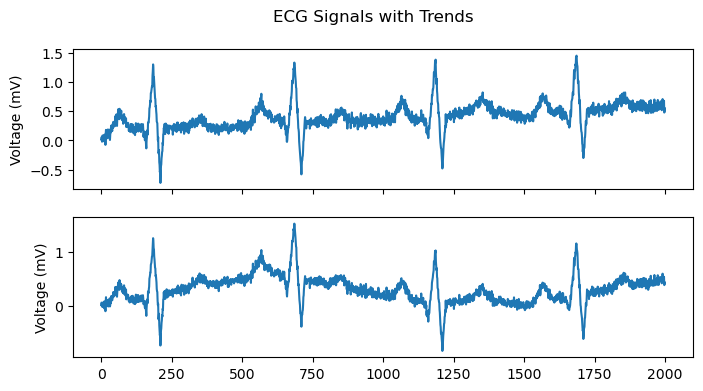

In [2]:
ecgl = io.loadmat("../data/ecgl.mat")
ecgnl = io.loadmat("../data/ecgnl.mat")

t_ecg = len(ecgl["ecgl"])
x_ecg = np.linspace(0, t_ecg, t_ecg)

fig_ecg, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

ax1.plot(ecgl["ecgl"])
ax1.set(ylabel="Voltage (mV)")
ax2.plot(ecgnl["ecgnl"])
ax2.set(ylabel="Voltage (mV)")
fig_ecg.suptitle("ECG Signals with Trends")
# plt.savefig("../images/find-trend.png")

### De-trend

Text(0.5, 0.98, 'Detrended ECG Signals')

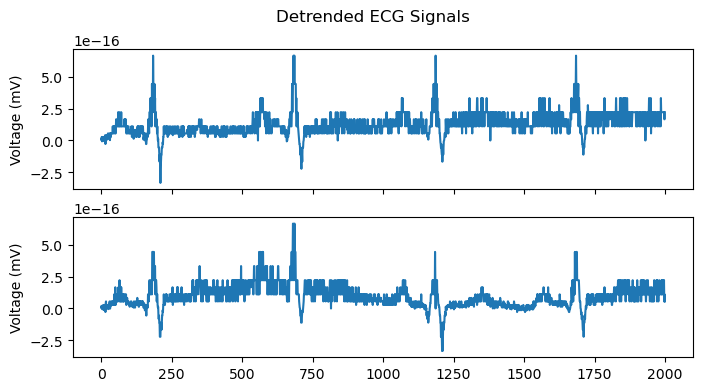

In [3]:
dt_ecgl = signal.detrend(
    ecgl["ecgl"], axis=-1, type="linear", bp=0, overwrite_data=False
)
dt_ecgnl = signal.detrend(
    ecgnl["ecgnl"], axis=-1, type="linear", bp=0, overwrite_data=False
)
fig_ecgd, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

ax_1.plot(dt_ecgl)
ax_1.set(ylabel="Voltage (mV)")

ax_2.plot(dt_ecgnl)
ax_2.set(ylabel="Voltage (mV)")
fig_ecgd.suptitle("Detrended ECG Signals")
# plt.savefig("../images/find-trend2.png")

In [4]:
openLoop = io.loadmat("../data/openloop60hertz.mat")
Fs = 1000

### Butterworth

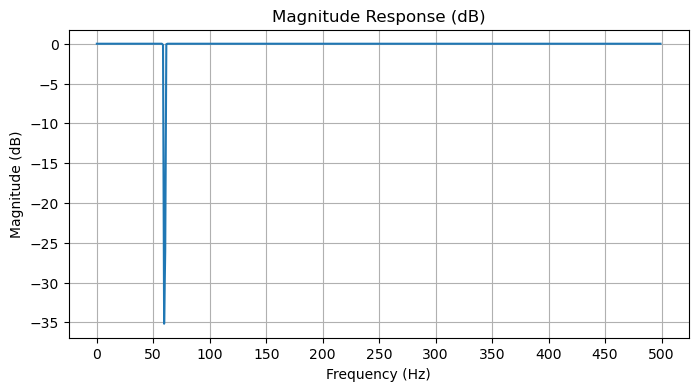

In [5]:
nom, denom = signal.iirfilter(
    N=5, Wn=[59, 61], btype="bandstop", analog=False, ftype="butter", fs=Fs
)
freq, h = signal.freqz(nom, denom, fs=Fs)
_, ax_bw = plt.subplots(figsize=(8, 4))
ax_bw.plot(freq, 20 * np.log10(np.abs(h)))
ax_bw.set(
    xlabel="Frequency (Hz)",
    ylabel="Magnitude (dB)",
    title="Magnitude Response (dB)",
    xticks=np.arange(0, 501, 50),
)
ax_bw.grid()
# plt.savefig("../images/find-butterworth.png")
plt.show()

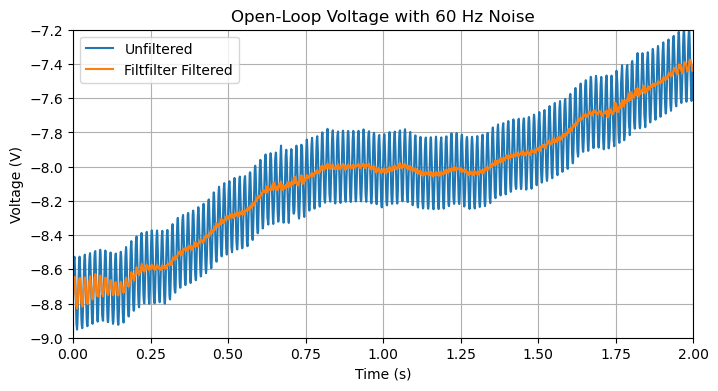

In [6]:
x_volt = openLoop["openLoopVoltage"]
t_volt = np.arange(len(x_volt)) / Fs

buttLoop = signal.filtfilt(nom, denom, x_volt.flatten())
# savgolLoop = signal.savgol_filter(x_volt.flatten(), 17, 1)
_, ax_bwf = plt.subplots(figsize=(8, 4))
ax_bwf.plot(t_volt, x_volt, label="Unfiltered")
ax_bwf.plot(t_volt, buttLoop, label="Filtfilter Filtered")
# ax_bwf.plot(t_volt, savgolLoop, label="Savgol Filtered")
ax_bwf.set(
    xlabel="Time (s)",
    ylabel="Voltage (V)",
    title="Open-Loop Voltage with 60 Hz Noise",
    xlim=(0, 2),
    ylim=(-9, -7.2),
)
ax_bwf.legend()
ax_bwf.grid()
# plt.savefig("../images/find-filtfilter.png")
plt.show()

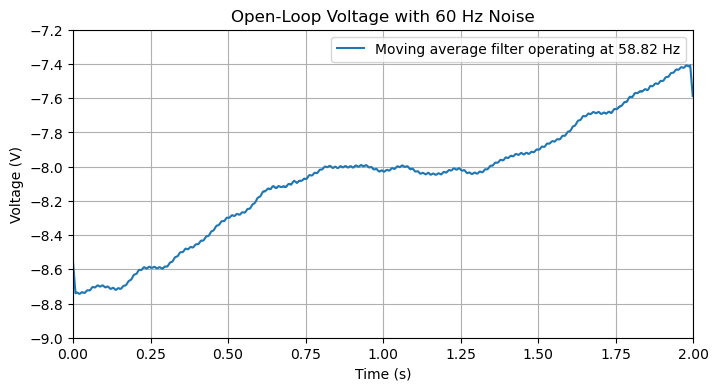

In [7]:
# buttLoop = signal.filtfilt(nom, denom, x_volt.flatten())
savgolLoop = signal.savgol_filter(x_volt.flatten(), 17, 1)
_, ax_bwf2 = plt.subplots(figsize=(8, 4))
# ax_bwf2.plot(t_volt, x_volt, label="Unfiltered")
# ax_bwf.plot(t_volt, buttLoop, label="Filtfilter Filtered")
ax_bwf2.plot(t_volt, savgolLoop, label="Moving average filter operating at 58.82 Hz")
ax_bwf2.set(
    xlabel="Time (s)",
    ylabel="Voltage (V)",
    title="Open-Loop Voltage with 60 Hz Noise",
    xlim=(0, 2),
    ylim=(-9, -7.2),
)
ax_bwf2.legend()
ax_bwf2.grid()
# plt.savefig("../images/find-savgol.png")
plt.show()

### Resampling

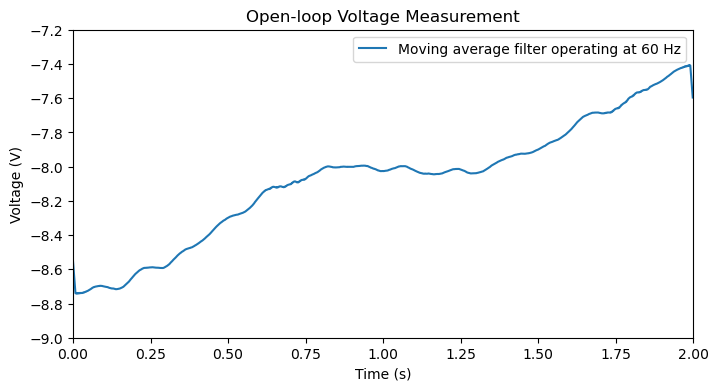

In [8]:
fsResamp = 1020
vResamp = signal.resample(
    x_volt.flatten(),
    int(x_volt.size / Fs * fsResamp),
)
tResamp = np.arange(vResamp.size) / fsResamp
vAvgResamp = signal.savgol_filter(vResamp, 17, 1)
_, ax_rs = plt.subplots(figsize=(8, 4))
ax_rs.plot(
    tResamp,
    vAvgResamp,
    label="Moving average filter operating at 60 Hz",
)
ax_rs.set(
    xlabel="Time (s)",
    ylabel="Voltage (V)",
    title="Open-loop Voltage Measurement",
    xlim=(0, 2),
    ylim=(-9, -7.2),
)
ax_rs.legend()
# plt.savefig("../images/find-resample.png")

In [9]:
train = io.loadmat("../data/train.mat")
train_wnoise = train["y"].flatten()
train_wnoise[::400] = 2.1
train["y"]

array([[-0.0306854 ],
       [-0.00114712],
       [-0.01061084],
       ...,
       [-0.00344135],
       [ 0.01290508],
       [ 0.01634643]])

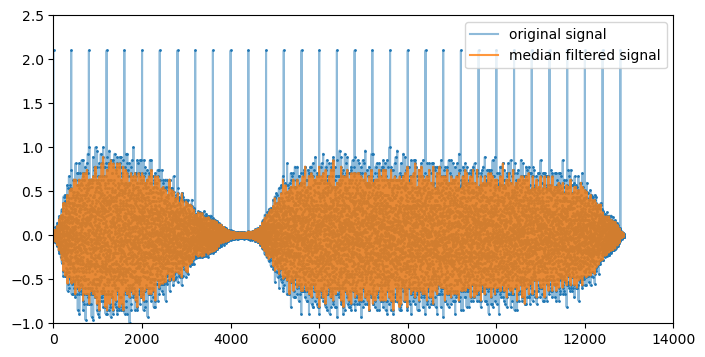

In [10]:
_, ax_hp = plt.subplots(figsize=(8, 4))
ax_hp.scatter(np.arange(12880) + 1, train_wnoise, s=1)
ax_hp.plot(train_wnoise, label="original signal", alpha=0.5)
ax_hp.plot(signal.medfilt(train_wnoise, 3), label="median filtered signal", alpha=0.8)
ax_hp.legend()
ax_hp.set(xlim=[0, 14000], ylim=[-1, 2.5])
# plt.savefig("../images/filter-med.png")
plt.show()

### Hampel Filter

In [11]:
def hampel(x, k, n_sigma=3):
    arraySize = len(x)
    idx = np.arange(arraySize)
    output_x = x.copy()
    output_idx = np.zeros_like(x)

    for i in range(arraySize):
        mask1 = np.where(idx >= (idx[i] - k), True, False)
        mask2 = np.where(idx <= (idx[i] + k), True, False)
        kernel = np.logical_and(mask1, mask2)
        median = np.median(x[kernel])
        std = 1.4826 * np.median(np.abs(x[kernel] - median))
        if np.abs(x[i] - median) > n_sigma * std:
            output_idx[i] = 1
            output_x[i] = median

    return output_x, output_idx.astype(bool)

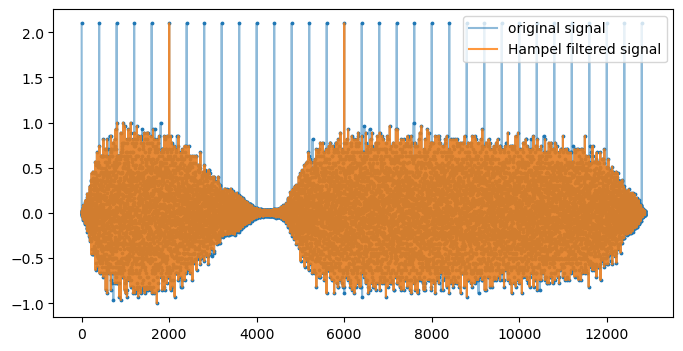

In [12]:
train_noise = pd.Series(train_wnoise.tolist())
train_wnoise_imp, _ = hampel(train_noise, k=11 // 2, n_sigma=3)
train_wnoise_out, train_wnoise_out_idx = hampel(train_noise, k=11 // 2, n_sigma=20)
_, ax_hp2 = plt.subplots(figsize=(8, 4))
ax_hp2.plot(train_wnoise, label="original signal", alpha=0.5)
ax_hp2.scatter(np.arange(12880) + 1, train_wnoise, s=3)
ax_hp2.plot(train_wnoise_imp, label="Hampel filtered signal", alpha=0.8)
# ax_hp2.scatter(
#     train_wnoise_out,
#     train_wnoise[np.array(train_wnoise_out_idx)],
#     c="w",
#     marker="s",
#     edgecolors="black",
#     label="outliers",
# )
ax_hp2.legend()
# plt.savefig("../images/filter-hampel.png")

## Finding Simple Features

### Example 1: Find Large Signal Values in 1D-Data

In [13]:
# Create a sine-wave
dt = 0.1
duration = 20
time = np.arange(0, duration, dt)
data = np.sin(time)

# Set a threshold
threshold = 0.7
# Find the (binary) indices of all data above that threshold
is_large = data > threshold

# For plotting of "large" data, set all "not large" data to "np.nan"
# Note that I explicitly copy the data!
large_data = data.copy()
large_data[~is_large] = np.nan

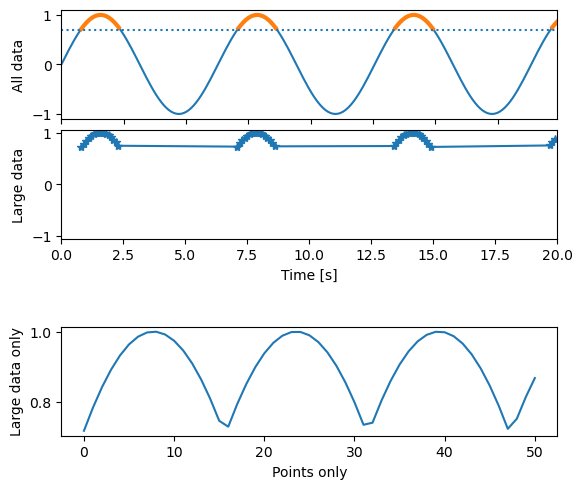

In [14]:
# Plot the data
fig, axs = plt.subplots(3, 1)

axs[0].plot(time, data)
axs[0].plot(time, large_data, lw=3)
axs[1].plot(time[is_large], data[is_large], "*-")
axs[2].plot(data[is_large])

# Format the plot
axs[0].axhline(threshold, ls="dotted")
axs[0].margins(x=0)
axs[0].set(ylabel="All data", xticklabels=([]))

axs[1].margins(x=0)
axs[1].set(
    xlabel="Time [s]",
    ylabel="Large data",
    xlim=(0, duration),
    ylim=(-1.05, 1.05),
)

axs[2].set(xlabel="Points only", ylabel="Large data only")

# Group the top two axes, since they have the same x-scale
axs[0].set(position=[0.125, 0.75, 0.775, 0.227])
axs[1].set(position=[0.125, 0.50, 0.775, 0.227])
axs[2].set(position=[0.125, 0.09, 0.775, 0.227])

plt.show()

### Example 2: Find Start and End of a Movement

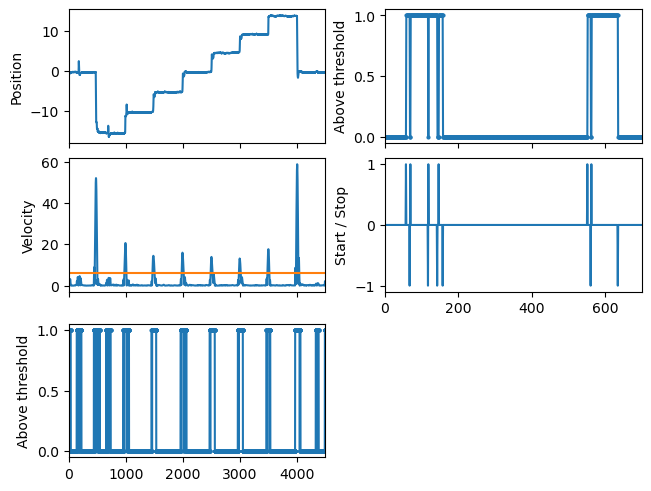

In [15]:
# Get eye positions, sampled with 100 Hz
rate = 100
hor_pos = io.loadmat("../data/HorPos.mat")["HorPos"][:, 0]

# General layout of the plot
_, ax_f = plt.subplots(3, 2, constrained_layout=True)

# Select an interesting domain
my_domain = range(9000, 13500)
ax_f[0, 0].plot(hor_pos[my_domain])
ax_f[0, 0].set(ylabel="Position", xticklabels=[])
ax_f[0, 0].margins(x=0)

# Plot the absolute eye velocity
eye_vel = signal.savgol_filter(
    hor_pos, window_length=71, polyorder=3, deriv=1, delta=1 / rate
)
eye_vel_abs = np.abs(eye_vel)
ax_f[1, 0].plot(eye_vel_abs[my_domain])

# Set a default threshold, in case the threshold is not determined interactively
thres = 6.3
ax_f[1, 0].axhline(thres, color="C1")
ax_f[1, 0].margins(x=0)
ax_f[1, 0].set(ylabel="Velocity", xticklabels=[])

# Plot3: show where the absolute velocity exceeds the threshold
is_fast = eye_vel_abs > threshold
ax_f[2, 0].plot(is_fast[my_domain], "o-", ms=2)
ax_f[2, 0].set(ylabel="Above threshold")
ax_f[2, 0].margins(x=0)

# Plot4: as Plot3, but zoomed in
close_domain = range(9900, 10600, 1)
ax_f[0, 1].plot(is_fast[close_domain], "o-", ms=2)
ax_f[0, 1].set(ylabel="Above threshold", xticklabels=[])
ax_f[0, 1].margins(x=0)

# Plot5: Find the start and end of each movement
start_stop = np.diff(is_fast * 1)  # "*1": to convert boolean signal to numerical
ax_f[1, 1].plot(start_stop[close_domain])
ax_f[1, 1].set(ylabel="Start / Stop")
ax_f[1, 1].margins(x=0)

ax_f[2, 1].axis("off")
plt.show()

### Example 3: Find Bright Pixels in Grayscale Image

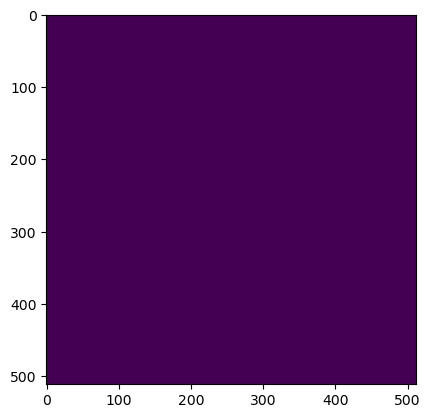

In [16]:
camera = plt.imread("../data/camera.png")
bright_threshold = 120
is_bright = camera > bright_threshold
plt.imshow(is_bright)

In [17]:
def corr_vis(x: np.ndarray, y: np.ndarray) -> None:
    """Visualize correlation, by calculating the cross-correlation of two
    signals, one point at a time. The aligned signals and the resulting corss
    correlation value are shown, and advanced when the user hits a key or
    clicks with the mouse.

    Parameters
    ----------
        X : Comparison signal
        Y : Reference signal

    Example
    -------
    x = np.r_[0:2*pi:10j]
    y = sin(x)
    corr_vis(y,x)

    Notes
    -----
    Based on an idea from dpwe@ee.columbia.edu
    """

    Nx = x.size
    Ny = y.size
    Nr = Nx + Ny - 1

    xmin = -(Nx - 1)
    xmax = Ny + Nx - 1

    # Generate figure and axes
    if "fig" not in locals():
        _, axs = plt.subplots(3, 1)

    # First plot: Signal 1
    axs[0].plot(range(Ny), y, "-", label="signal")
    ax = axs[0].axis()
    axs[0].axis([xmin, xmax, ax[2], ax[3]])
    axs[0].xaxis.grid(1)
    axs[0].set(ylabel="Y[n]", xticklabels=[])
    axs[0].legend()

    # Pre-calculate limits of correlation output
    axr = [
        xmin,
        xmax,
        np.correlate(x, y, "full").min(),
        np.correlate(x, y, "full").max(),
    ]

    # Make a version of y padded to the full extent of X's we'll shift
    padY = np.r_[np.zeros(Nx - 1), y, np.zeros(Nx - 1)]
    Npad = padY.size
    R = []

    # Generate the cross-correlation, step-by-step
    for p in range(Nr):
        # Figure aligned X
        axs[1].cla()
        axs[1].plot(np.arange(Nx) - Nx + p + 1, x, "--", label="feature")

        ax = axs[1].axis()
        axs[1].axis([xmin, xmax, ax[2], ax[3]])
        axs[1].xaxis.grid(True)
        axs[1].set_ylabel("X[n-m]")
        axs[1].set_xticklabels(())
        axs[1].legend()

        # Calculate correlation
        # Pad an X to the appropriate place
        padX = np.r_[np.zeros(p), x, np.zeros(Npad - Nx - p)]
        R = np.r_[R, np.sum(padX * padY)]

        # Third plot: cross-correlation values
        axs[2].cla()
        axs[2].plot(
            np.arange(len(R)) - (Nx - 1),
            R,
            "o-",
            linewidth=2,
            color="C1",
            label="cross-correlation",
        )
        axs[2].axis(axr)
        axs[2].grid(1)
        axs[2].set(xlabel="Steps", ylabel="$R_{xy}[m]$")
        axs[2].legend()

        # Update the plot
        plt.draw()

## Cross-Correlation

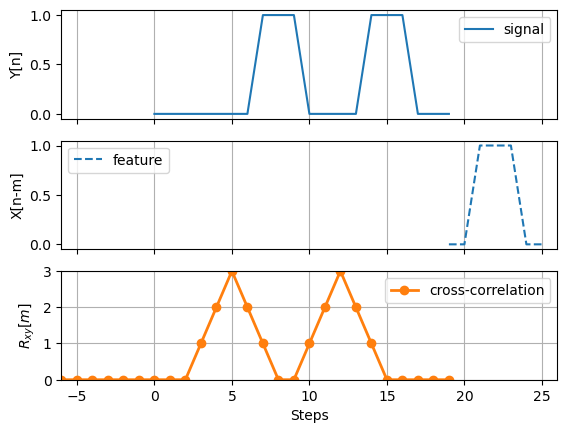

In [18]:
# Generate the data
sig = np.zeros(20)
sig[7:10] = 1
sig[14:17] = 1

feat = np.zeros(7)
feat[2:5] = 1

corr_vis(feat, sig)
# plt.savefig("../images/cross-corr.png")
plt.show()

### Auto-correlation

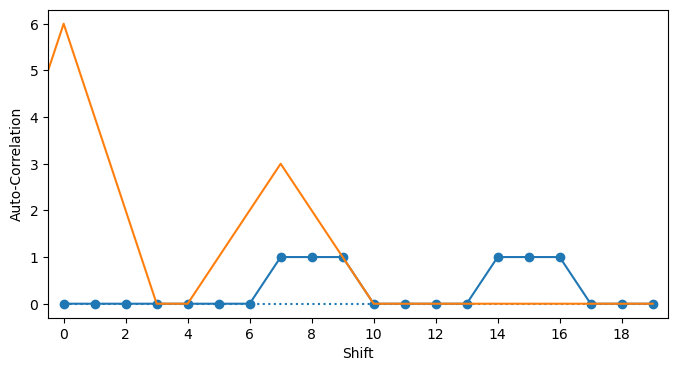

In [19]:
# Generate the data
signal_ac = np.zeros(20)
signal_ac[7:10] = 1
signal_ac[14:17] = 1

_, ax_ac = plt.subplots(figsize=(8, 4))

ax_ac.plot(signal_ac, "o-")
ax_ac.hlines(0, 0, 19, ls="dotted")
ax_ac.set(xlim=(-0.5, 19.5), xticks=np.arange(0, 20, 2))

# Determine the auto-correlation
auto_corr = np.correlate(signal_ac, signal_ac, "full")
shift = np.arange(len(auto_corr)) - (len(signal_ac) - 1)

# Plot the auto-correlation
ax_ac.plot(shift, auto_corr)
ax_ac.set(xlabel="Shift", ylabel="Auto-Correlation")
ax_ac.margins(x=0)
plt.show()

## Interpolation

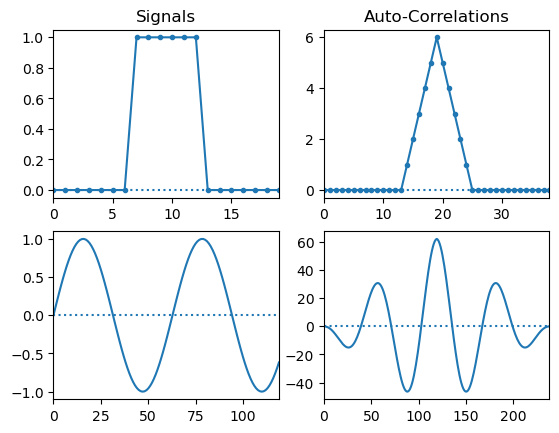

In [20]:
# Signal 1
x = np.zeros(20)
x[7:13] = 1
signals = [x]

# Signal 2
x = np.sin(np.arange(0, 12, 0.1))
signals.append(x)

# Make the plots
_, ax_acs = plt.subplots(2, 2)
styles = (".-", "-")
for ii, (sig_, sty_) in enumerate(zip(signals, styles)):
    ax_acs[ii, 0].plot(sig_, sty_)
    ax_acs[ii, 1].plot(np.correlate(sig_, sig_, mode="full"), sty_)
    for ax in ax_acs[ii]:
        ax.axhline(0, ls="dotted")
        ax.margins(x=0)

ax_acs[0, 0].set(title="Signals")
ax_acs[0, 1].set(title="Auto-Correlations")
# plt.savefig("../images/find-autocorr.png")
plt.show()

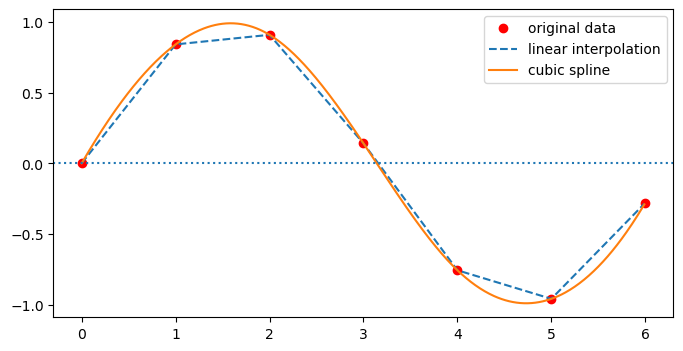

In [21]:
# Generate the data
xx = np.arange(7)
yy = np.sin(xx)

# Linear interpolation
xxi = np.arange(0, 6, 0.01)
yyi = np.interp(xxi, xx, yy)

# Cubic interpolation
cs = interpolate.CubicSpline(xx, yy)
yic = cs(xxi)

# Plot polynomial interpolations
_, ax_ip = plt.subplots(figsize=(8, 4))
ax_ip.plot(xx, yy, "ro", label="original data")
ax_ip.plot(xxi, yyi, ls="dashed", label="linear interpolation")
ax_ip.plot(xxi, yic, label="cubic spline")

# Format the plot
ax_ip.set(yticks=np.linspace(-1, 1, 5))
ax_ip.axhline(0, linestyle="dotted")
ax_ip.legend()
# plt.savefig("../images/find-interpol.png")